<a href="https://colab.research.google.com/github/kavyajeetbora/CityHealthMonitor/blob/master/development/internet_speed.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install -q h3
!pip install -q pydeck

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.2/1.2 MB 1.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.9/6.9 MB 18.7 MB/s eta 0:00:00


In [2]:
import geopandas as gpd
import numpy as np
import pandas as pd
import shapely
import h3
from matplotlib import colormaps
import pydeck as pdk

## Loading the internet speed data from AWS open data

In [3]:
url = "https://ookla-open-data.s3.us-west-2.amazonaws.com/parquet/performance/type=mobile/year=2019/quarter=1/2019-01-01_performance_mobile_tiles.parquet"
columns = ["avg_d_kbps", "tile"]
df = pd.read_parquet(url, columns=columns)
tile_geometries = shapely.from_wkt(df["tile"])

## Convert the geometry in string to shapely geometry
tile_centroids = shapely.centroid(tile_geometries)

## Create a geodataframe and export it to parquet file
gdf = gpd.GeoDataFrame(df[["avg_d_kbps"]], geometry=tile_centroids, crs='EPSG:4326')
gdf.to_parquet("internet-speeds.parquet")
gdf.head()

,avg_d_kbps,geometry
0,5983,POINT (-160.01862 70.63722)
1,3748,POINT (-160.04059 70.63357)
2,3364,POINT (-160.04059 70.63175)
3,2381,POINT (-160.03510 70.63357)
4,3047,POINT (-160.03510 70.63175)


`avg_d_kbps` is the average download speed for that data point in kilobits per second

In [4]:
gdf.shape[0]

3231245

## Clipping the geometry

Either we can clip the geometry by extends or by a geometry

- Using clipping/indexing of geometry by extends, we can use [`gdf.cx`](https://geopandas.org/en/stable/docs/reference/api/geopandas.GeoDataFrame.cx.html)function
- Using [`gdf.clip`](https://geopandas.org/en/stable/docs/reference/api/geopandas.GeoDataFrame.clip.html) we can clip the geometries in a geodataframe

In [5]:
!wget 'https://github.com/kavyajeetbora/CityHealthMonitor/raw/master/data/delhi_boundary.parquet' -O delhi_boundary.parquet
delhi = gpd.read_parquet("delhi_boundary.parquet")
delhi

--2024-05-02 11:20:27--  https://github.com/kavyajeetbora/CityHealthMonitor/raw/master/data/delhi_boundary.parquet
Resolving github.com (github.com)... 140.82.114.4
Connecting to github.com (github.com)|140.82.114.4|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/kavyajeetbora/CityHealthMonitor/master/data/delhi_boundary.parquet [following]
--2024-05-02 11:20:27--  https://raw.githubusercontent.com/kavyajeetbora/CityHealthMonitor/master/data/delhi_boundary.parquet
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.110.133, 185.199.111.133, 185.199.109.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.110.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 30078 (29K) [application/octet-stream]
Saving to: ‘delhi_boundary.parquet’

delhi_boundary.parq 100%[===================>]  29.37K  --.-KB/s    in 0.002s  

2024-05-02 11:20:27 (12.5 MB/

,geometry
0,"POLYGON ((76.83180 28.58173, 76.83853 28.55703..."


In [17]:
delhi_gdf = gdf.copy().clip(delhi['geometry'][0])
delhi_gdf['avg_d_MBPS'] = delhi_gdf['avg_d_kbps']*(1e-3)/8
delhi_gdf.drop(['avg_d_kbps'],axis=1,inplace=True)
delhi_gdf.shape[0]

3600

In [18]:
delhi_gdf.sample(2)

,geometry,avg_d_MBPS
2036772,POINT (77.06635 28.67854),1.43950
2036955,POINT (77.11578 28.67854),1.31375


## Converting the point to uber h3 spatial indices

In [45]:
# find hexs containing the points

APERTURE_SIZE = 7
hex_col = 'hex'+str(APERTURE_SIZE)

delhi_gdf[hex_col] = delhi_gdf.apply(lambda x: h3.geo_to_h3(x.geometry.y,x.geometry.x,APERTURE_SIZE),1)
delhi_gdf.sample(5)

,geometry,avg_d_MBPS,hex5,hex9,hex8,hex7
2040317,POINT (77.26959 28.54351),1.646500,853da107fffffff,893da1074d7ffff,883da1074dfffff,873da1074ffffff
2035894,POINT (77.01691 28.77488),0.826750,853da183fffffff,893da18e403ffff,883da18e41fffff,873da18e4ffffff
2036533,POINT (77.16522 28.76525),1.905875,853da1bbfffffff,893da1bb627ffff,883da1bb63fffff,873da1bb0ffffff
2036917,POINT (77.07733 28.63034),1.101000,853da113fffffff,893da112dcbffff,883da112ddfffff,873da112dffffff
2035627,POINT (76.95648 28.62551),0.400000,853da18bfffffff,893da189d3bffff,883da189d3fffff,873da189dffffff


In [46]:
# calculate temperature average per hex
network_data = delhi_gdf.groupby(hex_col)['avg_d_MBPS'].mean().to_frame('avg_d_MBPS').reset_index()
network_data.sample(5)

,hex7,avg_d_MBPS
121,873da1160ffffff,1.184444
265,873da1b91ffffff,1.003109
257,873da1ab0ffffff,1.243972
123,873da1162ffffff,1.227914
89,873da1133ffffff,0.932547


In [47]:
network_data.shape

(298, 2)

## Plotting the data on map

In [54]:
def color_code_value(value, cmap):
    color = cmap(value)
    scaled_colors = list(map(lambda x: int(x*255), color[:3]))
    scaled_alpha = int(color[3]*100)

    scaled_colors += [scaled_alpha]
    return scaled_colors

def colormap_dataframe(df, value_col, cmap):

    xdf = df.copy()

    ## Scale the temperature values between 0-1; using MinMax Scaler
    xdf[f'norm_{value_col}'] = (xdf[value_col]-xdf[value_col].min())/(xdf[value_col].max()-xdf[value_col].min())
    xdf['color'] = xdf[f'norm_{value_col}'].apply(lambda x: color_code_value(x, cmap))
    xdf[['R', 'G', 'B', 'A']] = pd.DataFrame(xdf['color'].to_list())
    xdf = xdf.drop(['color', f'norm_{value_col}'], axis=1)

    ## formatting the temperature value upto 1 decimal place
    xdf[value_col] = xdf[value_col].round(1)

    return xdf

def create_h3_hex_layer(df):

    # Define a layer to display on a map
    layer = pdk.Layer(
        "H3HexagonLayer",
        df,
        pickable=True,
        stroked=True,
        filled=True,
        extruded=False,
        get_hexagon=hex_col,
        get_fill_color="[R, G, B, A]"
    )

    return layer

tooltip = {
        "html": "Average Internet Speed: {avg_d_MBPS} MBPS",
        "style": {
            "backgroundColor": "#4CAF50",   # Green shade for background
            "color": "#FFFFFF",             # White for text color
            "border": "2px solid #4CAF50",  # Matching border color
            "borderRadius": "5px",          # Rounded corners
            "boxShadow": "2px 2px 10px rgba(0, 0, 0, 0.2)"  # Soft shadow effect
        }
    }


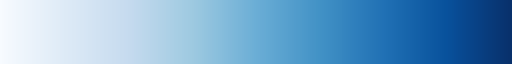

In [59]:
## Choose a colormap
cmap = colormaps['Blues']
cmap

In [60]:
## Apply the colormap to the dataframe
xdf = colormap_dataframe(df=network_data, value_col='avg_d_MBPS', cmap=cmap)

## Now create a H3HexagonLayer
layer = create_h3_hex_layer(xdf)

# Set the viewport location
view_state = pdk.ViewState(latitude=28.664, longitude=77.1062, zoom=11, bearing=0, pitch=30)

# Render
r = pdk.Deck(layers=[layer], initial_view_state=view_state, tooltip=tooltip)
r

<IPython.core.display.Javascript object>

{
  "initialViewState": {
    "bearing": 0,
    "latitude": 28.664,
    "longitude": 77.1062,
    "pitch": 30,
    "zoom": 11
  },
  "layers": [
    {
      "@@type": "H3HexagonLayer",
      "data": [
        {
          "A": 100,
          "B": 238,
          "G": 218,
          "R": 197,
          "avg_d_MBPS": 1.8,
          "hex7": "873da1000ffffff"
        },
        {
          "A": 100,
          "B": 247,
          "G": 236,
          "R": 224,
          "avg_d_MBPS": 0.9,
          "hex7": "873da1001ffffff"
        },
        {
          "A": 100,
          "B": 241,
          "G": 223,
          "R": 205,
          "avg_d_MBPS": 1.5,
          "hex7": "873da1002ffffff"
        },
        {
          "A": 100,
          "B": 240,
          "G": 221,
          "R": 201,
          "avg_d_MBPS": 1.7,
          "hex7": "873da1004ffffff"
        },
        {
          "A": 100,
          "B": 246,
          "G": 234,
          "R": 221,
          "avg_d_MBPS": 1.0,
          "hex7": "873da1005ffffff"
        },
        {
          "A": 100,
          "B": 241,
          "G": 223,
          "R": 205,
          "avg_d_MBPS": 1.5,
          "hex7": "873da1006ffffff"
        },
        {
          "A": 100,
          "B": 245,
          "G": 231,
          "R": 217,
          "avg_d_MBPS": 1.1,
          "hex7": "873da1009ffffff"
        },
        {
          "A": 100,
          "B": 246,
          "G": 234,
          "R": 221,
          "avg_d_MBPS": 0.9,
          "hex7": "873da100cffffff"
        },
        {
          "A": 100,
          "B": 238,
          "G": 218,
          "R": 196,
          "avg_d_MBPS": 1.9,
          "hex7": "873da100dffffff"
        },
        {
          "A": 100,
          "B": 224,
          "G": 201,
          "R": 157,
          "avg_d_MBPS": 2.7,
          "hex7": "873da1010ffffff"
        },
        {
          "A": 100,
          "B": 238,
          "G": 217,
          "R": 195,
          "avg_d_MBPS": 1.9,
          "hex7": "873da1011ffffff"
        },
        {
          "A": 100,
          "B": 241,
          "G": 224,
          "R": 206,
          "avg_d_MBPS": 1.5,
          "hex7": "873da1014ffffff"
        },
        {
          "A": 100,
          "B": 241,
          "G": 223,
          "R": 204,
          "avg_d_MBPS": 1.6,
          "hex7": "873da1015ffffff"
        },
        {
          "A": 100,
          "B": 230,
          "G": 208,
          "R": 173,
          "avg_d_MBPS": 2.4,
          "hex7": "873da1018ffffff"
        },
        {
          "A": 100,
          "B": 217,
          "G": 183,
          "R": 123,
          "avg_d_MBPS": 3.3,
          "hex7": "873da101cffffff"
        },
        {
          "A": 100,
          "B": 243,
          "G": 228,
          "R": 212,
          "avg_d_MBPS": 1.3,
          "hex7": "873da1020ffffff"
        },
        {
          "A": 100,
          "B": 244,
          "G": 229,
          "R": 213,
          "avg_d_MBPS": 1.2,
          "hex7": "873da1021ffffff"
        },
        {
          "A": 100,
          "B": 244,
          "G": 229,
          "R": 213,
          "avg_d_MBPS": 1.3,
          "hex7": "873da1022ffffff"
        },
        {
          "A": 100,
          "B": 242,
          "G": 226,
          "R": 209,
          "avg_d_MBPS": 1.4,
          "hex7": "873da1023ffffff"
        },
        {
          "A": 100,
          "B": 242,
          "G": 225,
          "R": 208,
          "avg_d_MBPS": 1.4,
          "hex7": "873da1024ffffff"
        },
        {
          "A": 100,
          "B": 242,
          "G": 225,
          "R": 207,
          "avg_d_MBPS": 1.5,
          "hex7": "873da1025ffffff"
        },
        {
          "A": 100,
          "B": 239,
          "G": 219,
          "R": 199,
          "avg_d_MBPS": 1.8,
          "hex7": "873da1026ffffff"
        },
        {
          "A": 100,
          "B": 246,
          "G": 233,
          "R": 219,
          "avg_d_MBPS": 1.0,
          "hex7": "873da1028